Hybird algorithm by Anthony

# Load Data

In [1]:
from recom_system.algorithms.preprocessing import get_ratings_datasets


trainset, testset = get_ratings_datasets(train_size=0.8, drop_zero=True)
print(f'{len(trainset.raw_ratings)=}, {len(testset)=}')


len(trainset.raw_ratings)=311390, len(testset)=51709


# Build Model

In [2]:
from recom_system.algorithms.models.hybird.svd_nn import SvdNCF


svdncf = SvdNCF(svd_params={'n_factors': 100, 'n_epochs': 20},
                ncf_params={'in_features': 200, 'out_features': 1},
)
%time svdncf.fit(trainset.build_full_trainset())

2024-04-25 15:25:57.325619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 15:25:58.045620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


CPU times: user 2.54 s, sys: 12.5 ms, total: 2.55 s
Wall time: 2.55 s


In [3]:
import torch

optimizer = torch.optim.Adam(svdncf.ncf.parameters(), lr=1e-3, weight_decay=1e-4)
loss_func = torch.nn.MSELoss()

losses = svdncf.train(optimizer, loss_func, epochs=20)

20/20: 100%|███████████████████████████████| 3893/3893 [00:11<00:00, 337.60it/s]


Text(0, 0.5, 'mse')

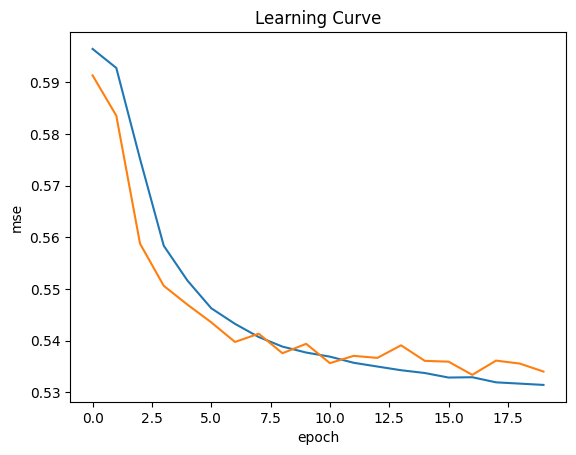

In [4]:
from matplotlib import pyplot as plt

train_loss, test_loss = zip(*losses)
plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(test_loss)), test_loss, label='test loss')
plt.title('Learning Curve')
plt.xlabel('epoch')
plt.ylabel('mse')

In [5]:
import pickle
import os
import torch


def save_model(model, path):
    svd = model.svd
    ncf = model.ncf
    path_svd = os.path.join(path, 'svd.pkl')
    path_ncf = os.path.join(path, 'ncf.pt')

    with open(path_svd, 'wb') as f:
        pickle.dump(svd, f)
    torch.save(ncf.state_dict(), path_ncf)
    return (path_svd, path_ncf)

save_model(svdncf, '.')

('./svd.pkl', './ncf.pt')

# Test

In [7]:
from recom_system.algorithms.models.hybird.svd_nn import SvdNCF

svdncf = SvdNCF.load('.')

In [8]:
from recom_system.algorithms.metrics import evaluate

results_svdncf = evaluate(svdncf, testset, ['rmse', 'ndcg@10', 'precision@20', 'recall@20'])
results_svdncf

/home/anthony/code/lucky-passbook/recom_system/algorithms/models/hybird/svd_nn.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  features = torch.Tensor(features)


{'rmse': 0.8419441945438784,
 'ndcg@10': 0.9930124882909631,
 'precision@20': 0.7469984416688996,
 'recall@20': 0.7974868373998171}